# Curso: Clusterização de dados: Segmentação de clientes

## Objetivos:
* Aprenda como conduzir um problema de machine learning do início ao fim, usando o pipeline de data science
* Entenda como importar e preparar os seus dados
* Aplique a análise exploratória de dados (AED) de forma eficiente
* Crie um modelo de clusterização, determinando o melhor número de clusters
* Compare o resultado de diferentes métodos para identificar o número correto de clusters
* Aprenda como apresentar os resultados de forma eficiente para toda a sua empresa
* Resolva um problema real, com dados reais

Link: https://cursos.alura.com.br/course/clusterizacao-dados-segmentacao-clientes

## Importando as bibliotecas necessárias

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

## Carregando os datasets e explorando os dados

In [75]:
df = pd.read_csv('datasets/BancoDeDados.csv')

In [76]:
df.head()

,amostra,id_cliente,id_unico_cliente,item_id,cep_cliente,cidade_cliente,estado_cliente,id_pedido,status_pedido,horario_pedido,...,pagamento_sequencial,pagamento_tipo,pagamento_prestacoes,pagamento_valor,review,categoria,categoria_ingles,cep_vendedor,cidade_vendedor,estado_vendedor
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,1,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,...,1,credit_card,2,146.87,4,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
1,1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,1,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,...,1,credit_card,1,275.79,1,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
2,2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,2,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,...,1,credit_card,1,275.79,1,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
3,3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,1,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,...,1,credit_card,7,140.61,3,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
4,4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,1,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,...,1,credit_card,10,137.58,4,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP


In [77]:
print(f'A base de dados é formado por {df.shape[0]} linhas e {df.shape[1]} atributos')

A base de dados é formado por 116581 linhas e 27 atributos


In [78]:
df.dtypes

amostra                   int64
id_cliente               object
id_unico_cliente         object
item_id                   int64
cep_cliente               int64
cidade_cliente           object
estado_cliente           object
id_pedido                object
status_pedido            object
horario_pedido           object
pedido_aprovado          object
pedido_entregador        object
pedido_entregue          object
data_estimada            object
id_vendedor              object
preco                   float64
frete                   float64
pagamento_sequencial      int64
pagamento_tipo           object
pagamento_prestacoes      int64
pagamento_valor         float64
review                    int64
categoria                object
categoria_ingles         object
cep_vendedor              int64
cidade_vendedor          object
estado_vendedor          object
dtype: object

In [79]:
def plot_perc(df, coluna):
    fig, ax = plt.subplots(figsize=(20,8))
    sns.countplot(x=coluna, data=df, orient='h', ax=ax)
    ax.set_ylabel('Contagem', fontsize=14)    

    sizes = []
    for p in ax.patches:
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x() + p.get_width()*0.60,
                height+200, 
                f'{height/116581:1.2%}',
                ha='center', va='bottom', fontsize=12)
    ax.set_ylim(0, max(sizes)*1.1)

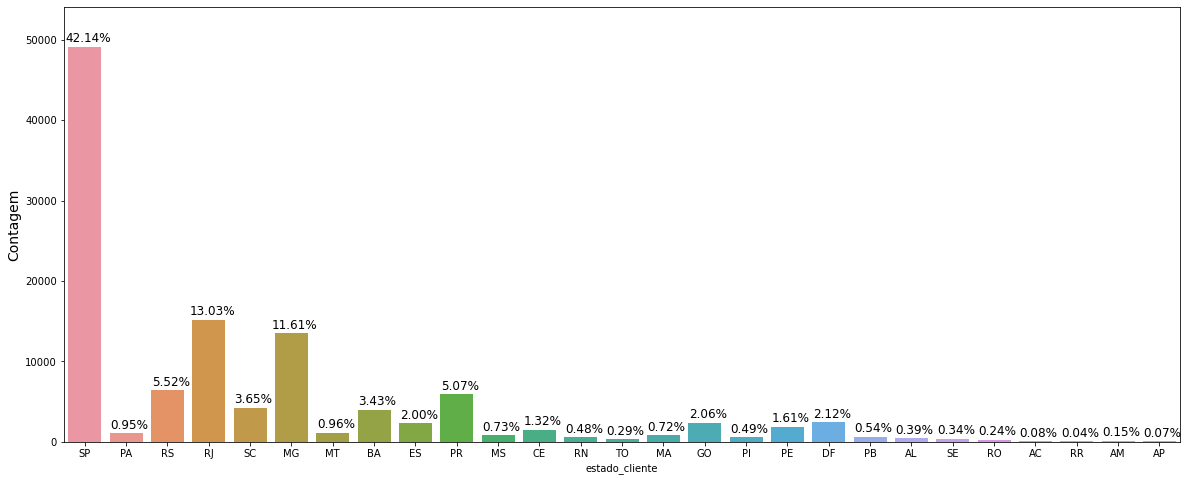

In [80]:
plot_perc(df, 'estado_cliente')

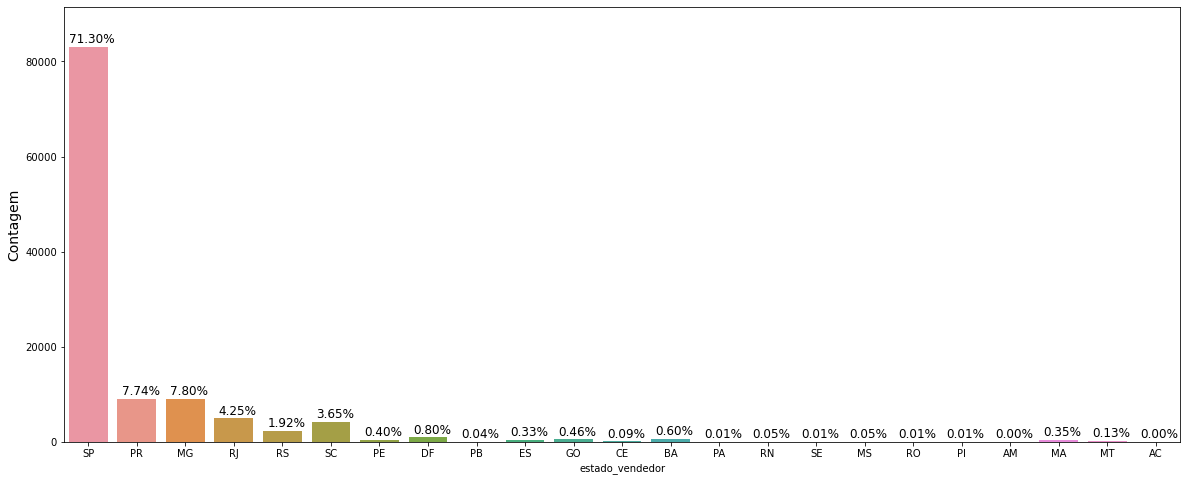

In [81]:
plot_perc(df, 'estado_vendedor')

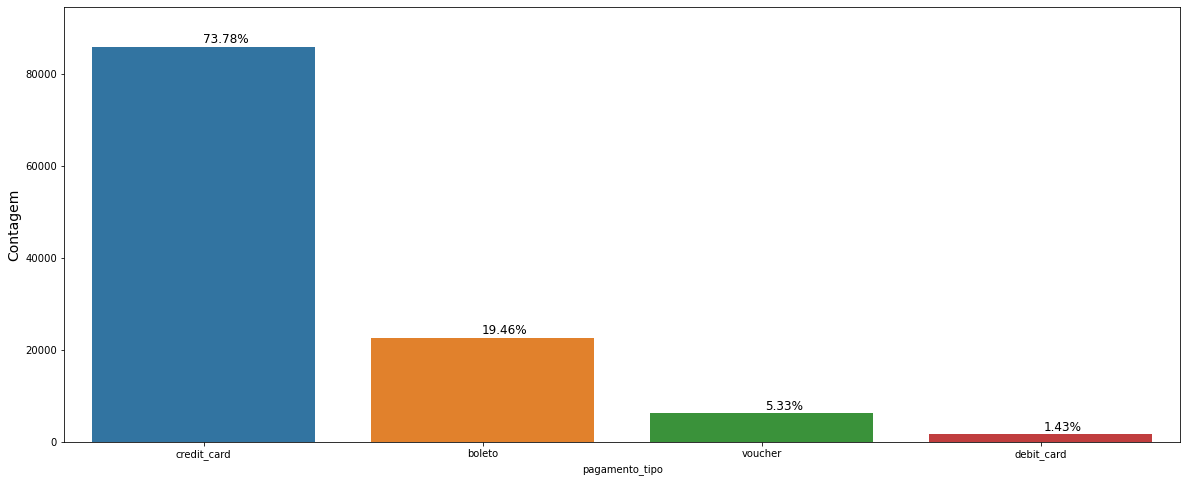

In [82]:
plot_perc(df, 'pagamento_tipo')

## Modelos RFM
### Recência (R)
Há quantos dias foi a última compra desse cliente?

### Frequência (F)
Quantas compras esse cliente já fez na sua empresa, desde que se cadastrou?

### Monetaridade (M)
Quanto esse cliente já gastou em dinheiro na sua empresa

In [83]:
df_olist = df[['id_unico_cliente', 'id_cliente', 'horario_pedido', 'item_id', 'preco']].copy()

df_compra = df.groupby('id_unico_cliente')['horario_pedido'].max().reset_index()
df_compra.rename({'horario_pedido': 'data_maxima_compra'}, axis=1, inplace=True)
df_compra['data_maxima_compra'] = pd.to_datetime(df_compra['data_maxima_compra'])
df_compra['recencia'] = (df_compra.data_maxima_compra.max() - df_compra.data_maxima_compra).dt.days
df_compra.head()

,id_unico_cliente,data_maxima_compra,recencia
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,118
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,541
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,325
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,292


In [84]:
df_usuario = pd.merge(df_olist, df_compra[['id_unico_cliente', 'recencia']], on='id_unico_cliente')
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,recencia
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,1,112.99,298
2,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,2,112.99,298
3,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483
4,23397e992b09769faf5e66f9e171a241,6bc8d08963a135220ed6c6d098831f84,2018-02-03 19:45:40,1,106.99,211


In [85]:
def calcular_wcss(df):
    wcss = []
    for k in range(2, 20):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit_predict(df)
        wcss.append(kmeans.inertia_)
    return wcss

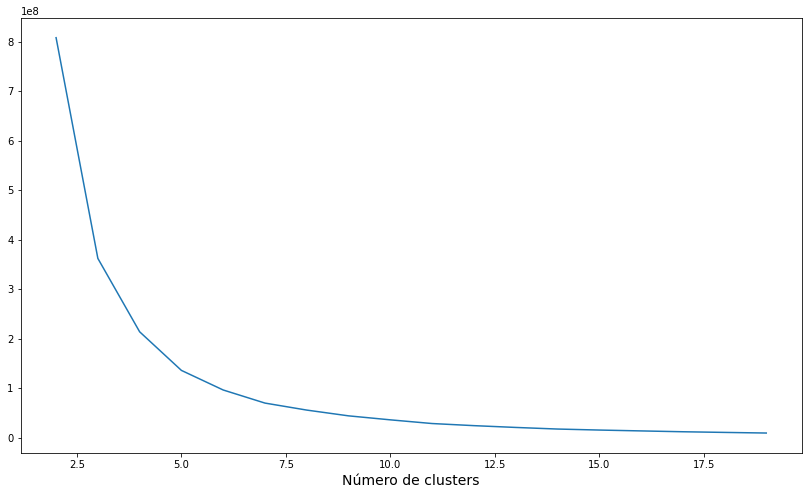

In [86]:
df_recencia = df_usuario[['recencia']].copy()
soma_quadrados = calcular_wcss(df_recencia)

fig, ax = plt.subplots(figsize=(14,8))
ax.plot(range(2,20), soma_quadrados)
ax.set_xlabel('Número de clusters', fontsize=14)
plt.show()

In [87]:
def numero_otimo_clusters(wcss):
    x0, y0 = 2, wcss[0]
    x1, y1 = 20, wcss[-1]
    
    distancias = []
    for i in range(len(wcss)):
        x = i+2
        y = wcss[i]
        
        numerador = abs((y1-y0)*x - (x1-x0)*y + x1*y0 - y1*x0)
        denominador = np.sqrt((y1-y0)**2 + (x1-x0)**2)
        distancias.append(numerador/denominador)
    return distancias.index(max(distancias))+2

In [88]:
numero_otimo_clusters(soma_quadrados)

5

In [89]:
kmeans = KMeans(n_clusters=5)
df_usuario['recenciaCluster'] = kmeans.fit_predict(df_recencia)
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,recencia,recenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,2
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,1,112.99,298,3
2,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,2,112.99,298,3
3,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,2
4,23397e992b09769faf5e66f9e171a241,6bc8d08963a135220ed6c6d098831f84,2018-02-03 19:45:40,1,106.99,211,1


In [90]:
agrupado_por_recencia_cluster = df_usuario.groupby('recenciaCluster', as_index=False)[['recencia']].mean()
agrupado_por_recencia_cluster_ordenado = agrupado_por_recencia_cluster.sort_values('recencia', ascending=False).reset_index(drop=True)
agrupado_por_recencia_cluster_ordenado['nova_ordenacao'] = agrupado_por_recencia_cluster_ordenado.index
teste_df = pd.merge(df_usuario, agrupado_por_recencia_cluster_ordenado[['recenciaCluster', 'nova_ordenacao']], on='recenciaCluster')
teste_df = teste_df.drop('recenciaCluster', axis=1).rename({'nova_ordenacao': 'recenciaCluster'}, axis=1)


In [91]:
def ordenador_cluster(cluster_nome, target_nome, df, ascending=True):
    df_ordenado = df.groupby(cluster_nome, as_index=False)[[target_nome]].mean()
    df_ordenado = df_ordenado.sort_values(target_nome, ascending=ascending).reset_index(drop=True)
    df_ordenado['nova_ordenacao'] = df_ordenado.index
    df = pd.merge(df, df_ordenado[[cluster_nome, 'nova_ordenacao']], on=cluster_nome)
    df = df.drop(cluster_nome, axis=1).rename({'nova_ordenacao': cluster_nome}, axis=1)
    return df

In [92]:
df_usuario = ordenador_cluster('recenciaCluster', 'recencia', df_usuario, False)
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,recencia,recenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0


In [93]:
df_usuario.groupby('recenciaCluster')['recencia'].describe()

,count,mean,std,min,25%,50%,75%,max
recenciaCluster,,,,,,,,
0,14084.0,518.441565,49.666936,453.0,478.0,512.0,549.0,728.0
1,19270.0,385.747172,35.573825,327.0,355.0,384.0,415.0,452.0
2,27987.0,266.439097,31.821787,212.0,237.0,271.0,289.0,326.0
3,30604.0,156.914260,31.155779,105.0,129.0,157.0,185.0,211.0
4,24636.0,52.519565,27.515153,0.0,28.0,48.0,77.0,104.0


In [94]:
def clusterizar_coluna(df, coluna, colunaCluster, ascending=True, n_clusters=5):
    df_coluna = df[[coluna]].copy()
    kmeans = KMeans(n_clusters)
    df[colunaCluster] = kmeans.fit_predict(df_coluna)
    df = ordenador_cluster(colunaCluster, coluna, df, ascending)
    return df    

In [95]:
df_frequencia = df.groupby('id_unico_cliente', as_index=False)['pedido_aprovado'].count()
df_frequencia.rename({'pedido_aprovado': 'frequencia'}, axis=1, inplace=True)
df_usuario = pd.merge(df_usuario, df_frequencia, on='id_unico_cliente')
df_usuario = clusterizar_coluna(df_usuario, 'frequencia', 'frequenciaCluster')

In [96]:
df_receita = df.groupby('id_unico_cliente', as_index=False)['pagamento_valor'].sum()
df_receita.rename({'pagamento_valor': 'receita'}, axis=1, inplace=True)
df_usuario = pd.merge(df_usuario, df_receita, on='id_unico_cliente')
df_usuario = clusterizar_coluna(df_usuario, 'receita', 'receitaCluster')

In [97]:
df_usuario.groupby('receitaCluster')[['receita']].mean()

,receita
receitaCluster,
0,233.904884
1,3600.221467
2,14904.747306
3,36830.054286
4,109312.640000


In [98]:
df_usuario['pontuacao'] = df_usuario['recenciaCluster'] + df_usuario['frequenciaCluster'] + df_usuario['receitaCluster']
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,recencia,recenciaCluster,frequencia,frequenciaCluster,receita,receitaCluster,pontuacao
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0,1,0,146.87,0,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0,1,0,140.61,0,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0,1,0,142.05,0,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0,1,0,155.70,0,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0,1,0,148.33,0,0


In [99]:
df_usuario.groupby('pontuacao')[['recencia', 'frequencia', 'receita']].mean()

,recencia,frequencia,receita
pontuacao,,,
0,517.655966,1.203912,182.006515
1,396.591766,1.418134,221.009046
2,279.388444,1.516372,247.027738
3,173.520539,1.649955,278.025814
4,73.220641,1.802610,331.018808
5,95.877803,6.506726,1408.405070
6,103.348584,9.389978,4074.884205
7,142.253125,13.712500,14437.819437
8,74.000000,9.000000,22249.420000


In [128]:
df_final = df_usuario[['id_unico_cliente', 'recencia', 'recenciaCluster', 'frequencia', 
                       'frequenciaCluster', 'receita', 'receitaCluster', 'pontuacao']].copy().drop_duplicates()
df_final.head()

,id_unico_cliente,recencia,recenciaCluster,frequencia,frequenciaCluster,receita,receitaCluster,pontuacao
0,861eff4711a542e4b93843c6dd7febb0,474,0,1,0,146.87,0,0
1,3c799d181c34d51f6d44bbbc563024db,483,0,1,0,140.61,0,0
2,567ab47ca4deb92d46dbf54dce07d0a7,528,0,1,0,142.05,0,0
3,f40ab89b622248b7ca125af4b486b887,474,0,1,0,155.70,0,0
4,749943913a9851a39c9baf51877fbab6,533,0,1,0,148.33,0,0


In [129]:
df_final['segmento'] = 'Inativo'
df_final.loc[df_final['pontuacao']>=1, 'segmento'] = 'Business'
df_final.loc[df_final['pontuacao']>=3, 'segmento'] = 'Master'
df_final.loc[df_final['pontuacao']>=5, 'segmento'] = 'Premium'
df_final.head()

,id_unico_cliente,recencia,recenciaCluster,frequencia,frequenciaCluster,receita,receitaCluster,pontuacao,segmento
0,861eff4711a542e4b93843c6dd7febb0,474,0,1,0,146.87,0,0,Inativo
1,3c799d181c34d51f6d44bbbc563024db,483,0,1,0,140.61,0,0,Inativo
2,567ab47ca4deb92d46dbf54dce07d0a7,528,0,1,0,142.05,0,0,Inativo
3,f40ab89b622248b7ca125af4b486b887,474,0,1,0,155.70,0,0,Inativo
4,749943913a9851a39c9baf51877fbab6,533,0,1,0,148.33,0,0,Inativo


In [130]:
df_final.to_csv('datasets/RFM.csv')

In [131]:
def plot_segmento(x, y, df):
    sns.set(palette='muted', color_codes=True, style='whitegrid')
    fig, ax = plt.subplots(figsize=(14,8))
    sns.scatterplot(x=x, y=y, data=df, hue='segmento', size='segmento', sizes=(50,150), 
                    size_order=['Premium', 'Master', 'Business', 'Inativo'])
    plt.show()

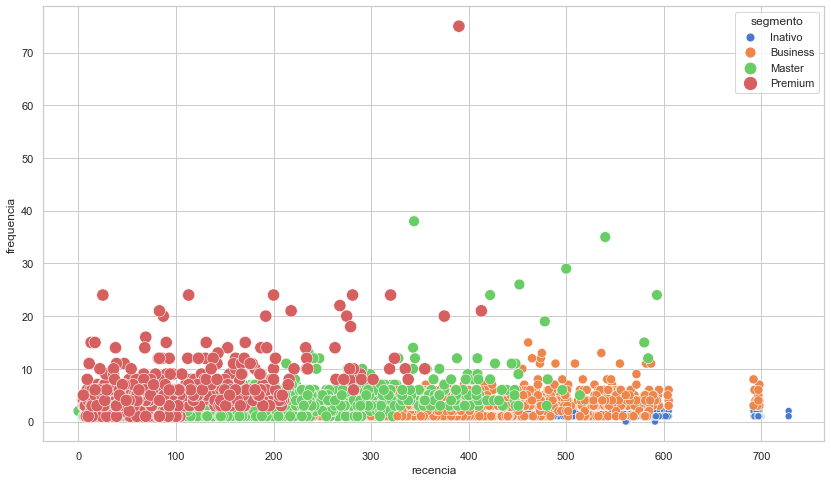

In [132]:
plot_segmento('recencia', 'frequencia', df_final)

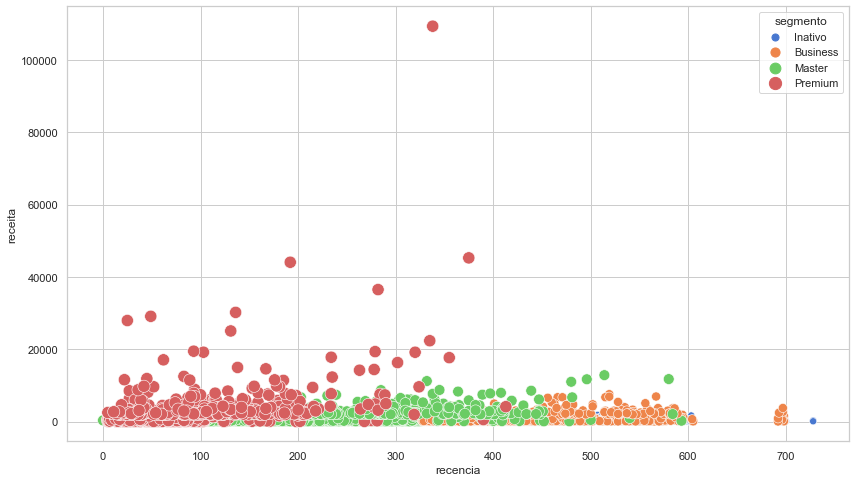

In [133]:
plot_segmento('recencia', 'receita', df_final)

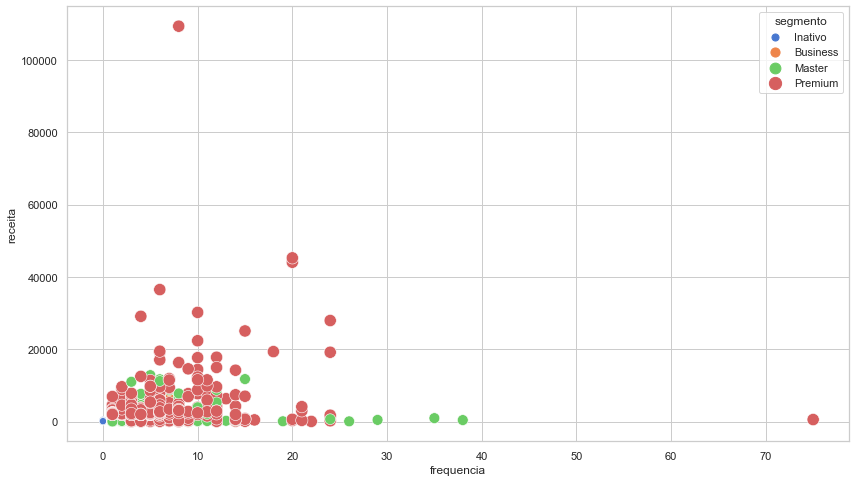

In [134]:
plot_segmento('frequencia', 'receita', df_final)

In [135]:
df_final[df_final['frequencia']> 70].drop_duplicates()

,id_unico_cliente,recencia,recenciaCluster,frequencia,frequenciaCluster,receita,receitaCluster,pontuacao,segmento
113356,9a736b248f67d166d2fbb006bcb877c3,390,1,75,4,556.13,0,5,Premium


In [136]:
df_final.drop_duplicates().shape

(94087, 9)

## Outra estratégia de segmento

In [140]:
df_final.loc[(df_final['recenciaCluster']==0) & (df_final['frequenciaCluster']==3) & (df_final['receitaCluster']==3),'Segmento'] = 'Campeao'

df_final.loc[(df_final['recenciaCluster']==1) & (df_final['frequenciaCluster']==3) & (df_final['receitaCluster']==3),'Segmento'] = 'Fiel'

df_final.loc[(df_final['recenciaCluster']==1) & (df_final['frequenciaCluster']==2) & (df_final['receitaCluster']==2),'Segmento'] = 'Potencialmente Fiel - Tipo 1'

df_final.loc[(df_final['recenciaCluster']==1) & (df_final['frequenciaCluster']==1) & (df_final['receitaCluster']==3),'Segmento'] = 'Potencialmente Fiel - Tipo 2'

df_final.loc[(df_final['recenciaCluster']==0) & (df_final['frequenciaCluster']==0) & (df_final['receitaCluster']==0),'Segmento'] = 'Novos'

df_final.loc[(df_final['recenciaCluster']==0) & (df_final['frequenciaCluster']==1) & (df_final['receitaCluster']==1),'Segmento'] = 'Promissores'

df_final.loc[(df_final['recenciaCluster']==2) & (df_final['frequenciaCluster']==2) & (df_final['receitaCluster']==2),'Segmento'] = 'Precisam Atencao'

df_final.loc[(df_final['recenciaCluster']==2) & (df_final['frequenciaCluster']==1) & (df_final['receitaCluster']==1),'Segmento'] ='Quase em Risco'

df_final.loc[(df_final['recenciaCluster']==3) & (df_final['frequenciaCluster']==2) & (df_final['receitaCluster']==2),'Segmento'] ='Risco'

df_final.loc[(df_final['recenciaCluster']==3) & (df_final['frequenciaCluster']==3) & (df_final['receitaCluster']==3),'Segmento'] ='Nao pode perder - Tipo 1'

df_final.loc[(df_final['recenciaCluster']==3) & (df_final['frequenciaCluster']==1) & (df_final['receitaCluster']==1),'Segmento'] ='Hibernando'

df_final.loc[(df_final['recenciaCluster']==3) & (df_final['frequenciaCluster']==0) & (df_final['receitaCluster']==0),'Segmento'] ='Perdidos'

In [141]:
def plot_segmento(x, y, df):
    ordem = []
    sns.set(palette='muted', color_codes=True, style='whitegrid')
    fig, ax = plt.subplots(figsize=(14,8))
    sns.scatterplot(x=x, y=y, data=df, hue='segmento')
    plt.show()

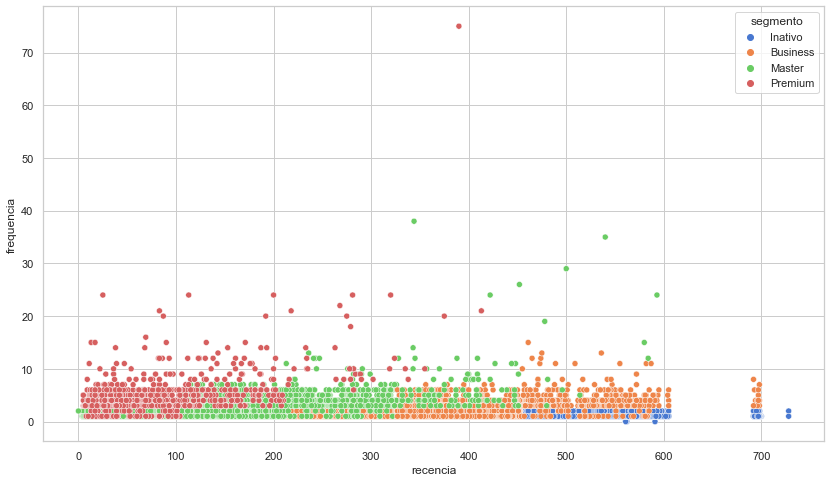

In [142]:
plot_segmento('recencia', 'frequencia', df_final)